[View in Colaboratory](https://colab.research.google.com/github/tenvol/tsf00/blob/master/feature_sets.ipynb)

#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Sets

**Learning Objective:** Create a minimal set of features that performs just as well as a more complex feature set

So far, we've thrown all of our features into the model. Models with fewer features use fewer resources and are easier to maintain. Let's see if we can build a model on a minimal set of housing features that will perform equally as well as one that uses all the features in the data set.

## Setup

As before, let's load and prepare the California housing data.

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [4]:
california_housing_dataframe.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
14888,-122.2,40.4,18.0,2102.0,377.0,1059.0,384.0,3.1,95500.0
213,-116.4,34.1,17.0,6683.0,1296.0,2677.0,1227.0,2.5,84000.0
7927,-118.4,33.9,38.0,2398.0,431.0,911.0,392.0,5.2,500001.0
6685,-118.3,34.1,43.0,3056.0,1345.0,3920.0,1304.0,1.9,300000.0
12263,-121.5,38.5,52.0,2037.0,358.0,811.0,375.0,4.4,162500.0


In [0]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [6]:
# Choose the first 12000 (out of 17000) examples for training.
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))

# Choose the last 5000 (out of 17000) examples for validation.
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_examples.describe())
print("Validation examples summary:")
display.display(validation_examples.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())

Training examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0,12000.0
mean,35.6,-119.6,28.6,2642.2,540.7,1430.2,502.0,3.9,2.0
std,2.1,2.0,12.6,2198.0,424.8,1169.2,386.9,1.9,1.2
min,32.5,-124.3,1.0,2.0,1.0,3.0,1.0,0.5,0.0
25%,33.9,-121.8,18.0,1459.0,296.0,787.0,281.0,2.6,1.5
50%,34.2,-118.5,29.0,2116.0,434.0,1167.0,409.0,3.5,1.9
75%,37.7,-118.0,37.0,3155.0,651.0,1723.2,607.0,4.7,2.3
max,42.0,-114.3,52.0,37937.0,6445.0,35682.0,6082.0,15.0,55.2


Validation examples summary:


,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0,5000.0
mean,35.6,-119.5,28.6,2647.2,536.3,1428.1,499.4,3.9,2.0
std,2.1,2.0,12.6,2136.2,413.5,1095.1,378.7,1.9,1.2
min,32.6,-124.3,2.0,11.0,3.0,8.0,3.0,0.5,0.1
25%,33.9,-121.8,18.0,1467.8,297.0,794.0,282.0,2.6,1.5
50%,34.2,-118.5,28.0,2161.0,433.0,1167.0,408.0,3.6,2.0
75%,37.7,-118.0,37.0,3141.2,643.2,1715.2,601.0,4.8,2.3
max,42.0,-114.6,52.0,25957.0,4798.0,11272.0,4490.0,15.0,52.0


Training targets summary:


,median_house_value
count,12000.0
mean,207.5
std,116.3
min,15.0
25%,119.9
50%,180.9
75%,265.3
max,500.0


Validation targets summary:


,median_house_value
count,5000.0
mean,206.8
std,115.2
min,15.0
25%,119.1
50%,178.8
75%,264.1
max,500.0


In [7]:
training_examples.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
14888,40.4,-122.2,18.0,2102.0,377.0,1059.0,384.0,3.1,2.0
213,34.1,-116.4,17.0,6683.0,1296.0,2677.0,1227.0,2.5,2.5
7927,33.9,-118.4,38.0,2398.0,431.0,911.0,392.0,5.2,2.6
6685,34.1,-118.3,43.0,3056.0,1345.0,3920.0,1304.0,1.9,0.8
12263,38.5,-121.5,52.0,2037.0,358.0,811.0,375.0,4.4,2.5


In [8]:
training_targets.head()

,median_house_value
14888,95.5
213,84.0
7927,500.0
6685,300.0
12263,162.5


In [9]:
validation_examples.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
3230,34.1,-117.9,33.0,2383.0,428.0,1269.0,421.0,4.6,1.9
2481,34.1,-117.6,16.0,13556.0,1704.0,5669.0,1668.0,6.5,2.4
11446,38.7,-121.2,14.0,3335.0,440.0,1329.0,429.0,6.2,2.5
3843,34.0,-118.0,36.0,1044.0,200.0,982.0,205.0,4.8,1.1
895,32.8,-117.1,20.0,2547.0,785.0,1199.0,643.0,1.8,2.1


In [10]:
validation_targets.head()

,median_house_value
3230,245.5
2481,311.5
11446,250.3
3843,153.9
895,140.3


In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of multiple features.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods
  
  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
  
  # 1. Create input functions.
  training_input_fn =lambda: my_input_fn(training_examples, training_targets, batch_size=1, shuffle=True, num_epochs=100)
  predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets, shuffle=False, num_epochs=1)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets, shuffle=False, num_epochs=1)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(input_fn=training_input_fn,
    steps=steps_per_period,
    )
    # 2. Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    validation_predictions = linear_regressor.predict(input_fn = predict_validation_input_fn)
    
    #print(training_predictions)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    #training_root_mean_squared_error = math.sqrt(
     #   metrics.mean_squared_error([1,3,2], [1,3,2]))
    #validation_root_mean_squared_error = math.sqrt(
     #   metrics.mean_squared_error([1,3,2], [1,3,2]))
    
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model of multiple features.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [0]:
fea = construct_feature_columns(training_examples)

In [15]:
type(fea)

set

In [16]:
print(fea)

set([_NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), _NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)])


In [17]:
for f in fea:
  print(f)

_NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)
_NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)


Training model...
RMSE (on training data):
  period 00 : 217.99
  period 01 : 200.61
  period 02 : 187.17
  period 03 : 178.36
  period 04 : 172.33
  period 05 : 169.09
  period 06 : 167.98
  period 07 : 167.63
  period 08 : 168.55
  period 09 : 169.28
Model training finished.


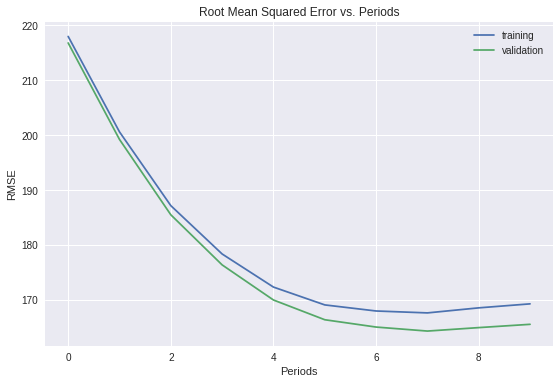

In [18]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

## Task 1: Develop a Good Feature Set

**What's the best performance you can get with just 2 or 3 features?**

A **correlation matrix** shows pairwise correlations, both for each feature compared to the target and for each feature compared to other features.

Here, correlation is defined as the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coefficient).  You don't have to understand the mathematical details for this exercise.

Correlation values have the following meanings:

  * `-1.0`: perfect negative correlation
  * `0.0`: no correlation
  * `1.0`: perfect positive correlation

In [23]:
correlation_dataframe = training_examples.copy()
correlation_dataframe["target"] = training_targets["median_house_value"]

correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.3,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.3,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Features that have strong positive or negative correlations with the target will add information to our model. We can use the correlation matrix to find such strongly correlated features.

We'd also like to have features that aren't so strongly correlated with each other, so that they add independent information.

Use this information to try removing features.  You can also try developing additional synthetic features, such as ratios of two raw features.

For convenience, we've included the training code from the previous exercise.

In [0]:
def construct_feature_columns(input_features):
  """Construct the TensorFlow Feature Columns.

  Args:
    input_features: The names of the numerical input features to use.
  Returns:
    A set of feature columns
  """ 
  return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [25]:
construct_feature_columns(training_examples)

{_NumericColumn(key='households', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='housing_median_age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='latitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='longitude', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='population', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='rooms_per_person', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='total_bedrooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None),
 _NumericColumn(key='total_rooms', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)}

In [0]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a linear regression model.
  
    Args:
      features: pandas DataFrame of features
      targets: pandas DataFrame of targets
      batch_size: Size of batches to be passed to the model
      shuffle: True or False. Whether to shuffle the data.
      num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
      Tuple of (features, labels) for next data batch
    """
    
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                           
    
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
      ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [0]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
  my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
  linear_regressor = tf.estimator.LinearRegressor(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer
  )
    
  # Create input functions.
  training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets["median_house_value"], 
                                          batch_size=batch_size)
  predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets["median_house_value"], 
                                                  num_epochs=1, 
                                                  shuffle=False)
  predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets["median_house_value"], 
                                                    num_epochs=1, 
                                                    shuffle=False)

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print("Training model...")
  print("RMSE (on training data):")
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.train(
        input_fn=training_input_fn,
        steps=steps_per_period,
    )
    # Take a break and compute predictions.
    training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
    training_predictions = np.array([item['predictions'][0] for item in training_predictions])
    
    validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
    validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print("Model training finished.")

  
  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

In [28]:
correlation_dataframe.corr()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,target
latitude,1.0,-0.9,0.0,-0.0,-0.1,-0.1,-0.1,-0.1,0.1,-0.1
longitude,-0.9,1.0,-0.1,0.0,0.1,0.1,0.1,-0.0,-0.1,-0.0
housing_median_age,0.0,-0.1,1.0,-0.3,-0.3,-0.3,-0.3,-0.1,-0.1,0.1
total_rooms,-0.0,0.0,-0.3,1.0,0.9,0.9,0.9,0.2,0.1,0.1
total_bedrooms,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,-0.0,0.1,0.0
population,-0.1,0.1,-0.3,0.9,0.9,1.0,0.9,0.0,-0.1,-0.0
households,-0.1,0.1,-0.3,0.9,1.0,0.9,1.0,0.0,-0.0,0.1
median_income,-0.1,-0.0,-0.1,0.2,-0.0,0.0,0.0,1.0,0.2,0.7
rooms_per_person,0.1,-0.1,-0.1,0.1,0.1,-0.1,-0.0,0.2,1.0,0.2
target,-0.1,-0.0,0.1,0.1,0.0,-0.0,0.1,0.7,0.2,1.0


Spend 5 minutes searching for a good set of features and training parameters. Then check the solution to see what we chose. Don't forget that different features may require different learning parameters.

Training model...
RMSE (on training data):
  period 00 : 166.56
  period 01 : 163.58
  period 02 : 162.94
  period 03 : 155.90
  period 04 : 153.95
  period 05 : 151.04
  period 06 : 150.38
  period 07 : 144.28
  period 08 : 141.67
  period 09 : 142.97
Model training finished.


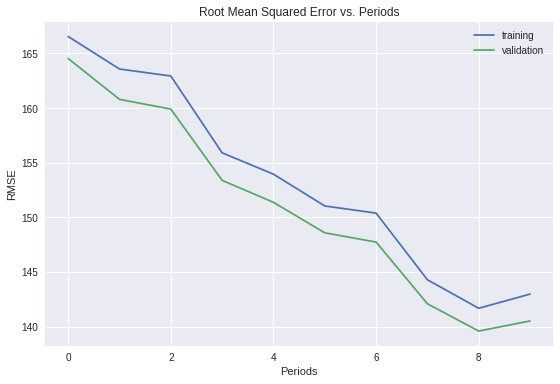

In [29]:
#
# Your code here: add your features of choice as a list of quoted strings.
#
minimal_features = ['latitude', 'longitude', 'housing_median_age', 'total_bedrooms', 'median_income', 'rooms_per_person']

assert minimal_features, "You must select at least one feature!"

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

#
# Don't forget to adjust these parameters.
#
train_model(
    learning_rate=0.001,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

### Solution

Click below for a solution.

Training model...
RMSE (on training data):
  period 00 : 165.99
  period 01 : 126.96
  period 02 : 118.57
  period 03 : 117.22
  period 04 : 116.93
  period 05 : 116.30
  period 06 : 115.62
  period 07 : 115.50
  period 08 : 115.16
  period 09 : 114.08
Model training finished.


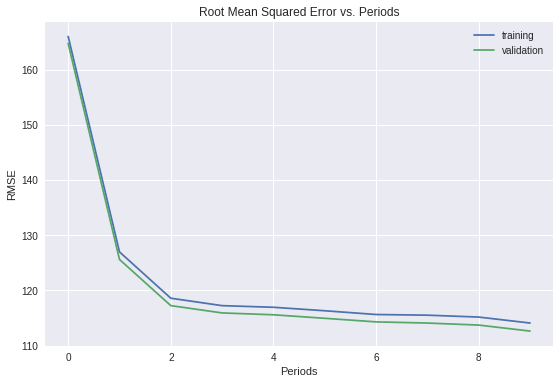

In [30]:
minimal_features = [
  "median_income",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 165.86
  period 01 : 125.60
  period 02 : 117.47
  period 03 : 116.63
  period 04 : 115.90
  period 05 : 115.54
  period 06 : 115.50
  period 07 : 114.85
  period 08 : 113.93
  period 09 : 113.72
Model training finished.


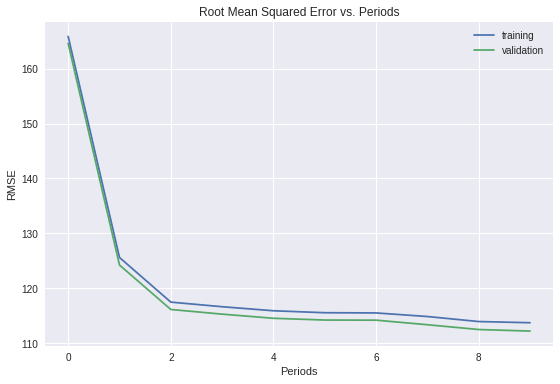

In [31]:
minimal_features = [
  "median_income",
  "rooms_per_person",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

## Task 2: Make Better Use of Latitude

Plotting `latitude` vs. `median_house_value` shows that there really isn't a linear relationship there.

Instead, there are a couple of peaks, which roughly correspond to Los Angeles and San Francisco.

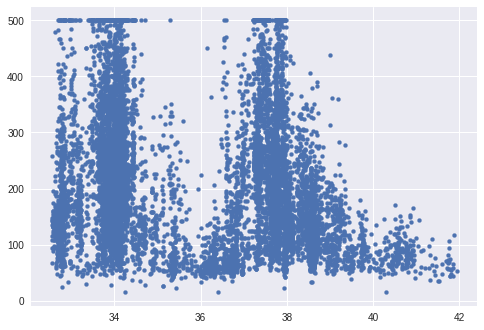

In [32]:
plt.scatter(training_examples["latitude"], training_targets["median_house_value"], s=16)

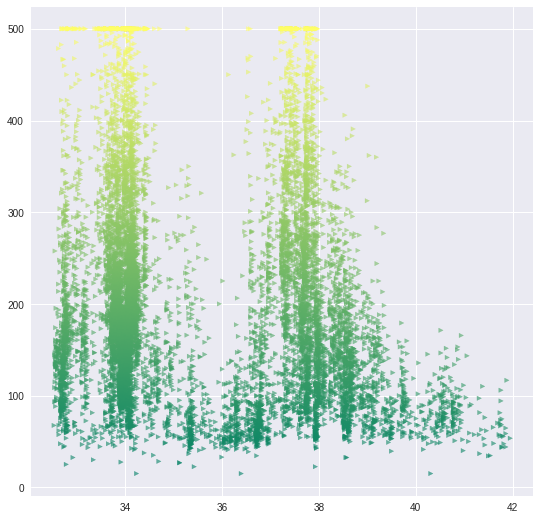

In [33]:
plt.figure(figsize=(9,9))
ax = plt.subplot(1,1,1)
plt.scatter(training_examples["latitude"], training_targets["median_house_value"], cmap='summer', c=training_targets["median_house_value"]/training_targets["median_house_value"].max(), marker=">", alpha=0.6, s=20)

In [0]:
plt.scatter??

**Try creating some synthetic features that do a better job with latitude.**

For example, you could have a feature that maps `latitude` to a value of `|latitude - 38|`, and call this `distance_from_san_francisco`.

Or you could break the space into 10 different buckets.  `latitude_32_to_33`, `latitude_33_to_34`, etc., each showing a value of `1.0` if `latitude` is within that bucket range and a value of `0.0` otherwise.

Use the correlation matrix to help guide development, and then add them to your model if you find something that looks good.

What's the best validation performance you can get?

In [0]:
#
# YOUR CODE HERE: Train on a new data set that includes synthetic features based on latitude.
#

In [0]:
from __future__ import print_function

import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

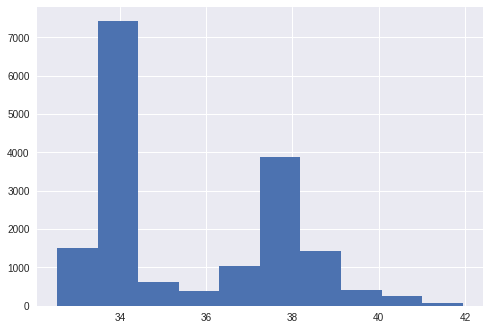

In [42]:
california_housing_dataframe['latitude'].hist(bins=10)

In [0]:
xlabels = ["{0} - {1}".format(i, i+1) for i in range(30,41,1)]

In [0]:
latlabels = ["latitude_{}_to_{}".format(i, i+1) for i in range(30,41,1)]

In [57]:
latlabels

['latitude_30_to_31',
 'latitude_31_to_32',
 'latitude_32_to_33',
 'latitude_33_to_34',
 'latitude_34_to_35',
 'latitude_35_to_36',
 'latitude_36_to_37',
 'latitude_37_to_38',
 'latitude_38_to_39',
 'latitude_39_to_40',
 'latitude_40_to_41']

In [58]:
xlabels

['30 - 31',
 '31 - 32',
 '32 - 33',
 '33 - 34',
 '34 - 35',
 '35 - 36',
 '36 - 37',
 '37 - 38',
 '38 - 39',
 '39 - 40',
 '40 - 41']

In [0]:
california_housing_dataframe['latitude_bucket_II'] = pd.cut(california_housing_dataframe['latitude'], range(30, 42, 1), right=False, labels=latlabels)

In [61]:
california_housing_dataframe.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,latitude_bucket_II
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,33 - 34,latitude_33_to_34
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,38 - 39,latitude_38_to_39
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,34 - 35,latitude_34_to_35
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0,34 - 35,latitude_34_to_35
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0,34 - 35,latitude_34_to_35
14209,-122.1,37.7,26.0,2607.0,682.0,1401.0,607.0,2.7,184100.0,37 - 38,latitude_37_to_38
3834,-118.0,34.2,17.0,7116.0,1089.0,3538.0,1083.0,6.3,273800.0,34 - 35,latitude_34_to_35
517,-117.0,32.6,15.0,4331.0,699.0,2046.0,627.0,4.0,193500.0,32 - 33,latitude_32_to_33
4503,-118.0,33.9,17.0,4807.0,838.0,3059.0,853.0,5.8,297300.0,33 - 34,latitude_33_to_34
13364,-121.9,37.3,14.0,6277.0,1742.0,3025.0,1630.0,4.1,234200.0,37 - 38,latitude_37_to_38


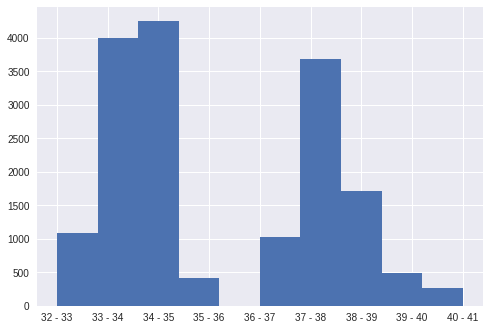

In [63]:
california_housing_dataframe['latitude_bucket'].hist()

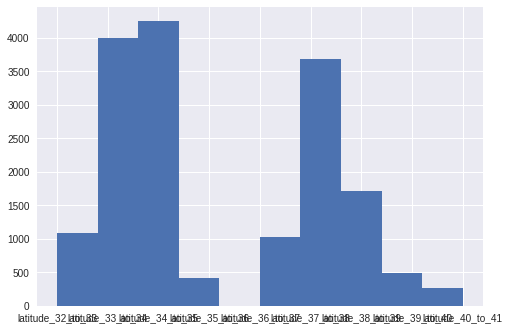

In [64]:
california_housing_dataframe['latitude_bucket_II'].hist()

In [0]:
xdum = pd.get_dummies(california_housing_dataframe['latitude_bucket'])

In [75]:
xdum

,30 - 31,31 - 32,32 - 33,33 - 34,34 - 35,35 - 36,36 - 37,37 - 38,38 - 39,39 - 40,40 - 41
2036,0,0,0,1,0,0,0,0,0,0,0
10256,0,0,0,0,0,0,0,0,1,0,0
2190,0,0,0,0,1,0,0,0,0,0,0
8014,0,0,0,0,1,0,0,0,0,0,0
7813,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
372,0,0,1,0,0,0,0,0,0,0,0
8182,0,0,0,0,1,0,0,0,0,0,0
8081,0,0,0,1,0,0,0,0,0,0,0
8906,0,0,0,0,1,0,0,0,0,0,0


Training model...
RMSE (on training data):
  period 00 : 165.85
  period 01 : 123.55
  period 02 : 118.39
  period 03 : 116.75
  period 04 : 116.26
  period 05 : 115.73
  period 06 : 115.04
  period 07 : 114.48
  period 08 : 113.98
  period 09 : 113.48
Model training finished.


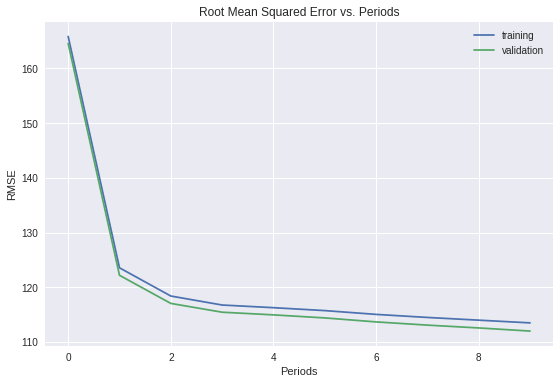

In [67]:
minimal_features = [
  "median_income",
  "rooms_per_person",
  "latitude",
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

In [68]:
california_housing_dataframe.tail(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,latitude_bucket_II
16918,-124.1,40.9,44.0,692.0,206.0,398.0,211.0,1.2,87500.0,40 - 41,latitude_40_to_41
8757,-118.6,34.1,43.0,2228.0,438.0,960.0,395.0,7.6,438500.0,34 - 35,latitude_34_to_35
7371,-118.3,34.1,42.0,2210.0,643.0,1228.0,605.0,2.6,315800.0,34 - 35,latitude_34_to_35
579,-117.0,32.8,17.0,4013.0,673.0,2263.0,661.0,5.1,148300.0,32 - 33,latitude_32_to_33
16841,-123.4,39.4,46.0,1748.0,362.0,808.0,330.0,2.9,76900.0,39 - 40,latitude_39_to_40
372,-116.9,32.8,16.0,2784.0,468.0,1458.0,465.0,4.0,184600.0,32 - 33,latitude_32_to_33
8182,-118.4,34.3,14.0,6235.0,1286.0,3568.0,1190.0,4.2,211600.0,34 - 35,latitude_34_to_35
8081,-118.4,33.9,39.0,2988.0,605.0,1466.0,610.0,4.9,341400.0,33 - 34,latitude_33_to_34
8906,-118.8,34.2,16.0,4975.0,949.0,2537.0,971.0,5.2,224700.0,34 - 35,latitude_34_to_35
1232,-117.1,33.4,17.0,2889.0,587.0,1931.0,510.0,3.9,208300.0,33 - 34,latitude_33_to_34


In [0]:
california_housing_dataframe_df = california_housing_dataframe.copy()

In [71]:
california_housing_dataframe_df.tail(6)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,latitude_bucket_II
16841,-123.4,39.4,46.0,1748.0,362.0,808.0,330.0,2.9,76900.0,39 - 40,latitude_39_to_40
372,-116.9,32.8,16.0,2784.0,468.0,1458.0,465.0,4.0,184600.0,32 - 33,latitude_32_to_33
8182,-118.4,34.3,14.0,6235.0,1286.0,3568.0,1190.0,4.2,211600.0,34 - 35,latitude_34_to_35
8081,-118.4,33.9,39.0,2988.0,605.0,1466.0,610.0,4.9,341400.0,33 - 34,latitude_33_to_34
8906,-118.8,34.2,16.0,4975.0,949.0,2537.0,971.0,5.2,224700.0,34 - 35,latitude_34_to_35
1232,-117.1,33.4,17.0,2889.0,587.0,1931.0,510.0,3.9,208300.0,33 - 34,latitude_33_to_34


In [0]:
california_housing_dataframe_df

In [0]:
xdummies = pd.get_dummies(california_housing_dataframe_df['latitude_bucket_II'])

In [81]:
xdummies

,latitude_30_to_31,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
2036,0,0,0,1,0,0,0,0,0,0,0
10256,0,0,0,0,0,0,0,0,1,0,0
2190,0,0,0,0,1,0,0,0,0,0,0
8014,0,0,0,0,1,0,0,0,0,0,0
7813,0,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
372,0,0,1,0,0,0,0,0,0,0,0
8182,0,0,0,0,1,0,0,0,0,0,0
8081,0,0,0,1,0,0,0,0,0,0,0
8906,0,0,0,0,1,0,0,0,0,0,0


In [82]:
california_housing_dataframe_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,latitude_bucket_II
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,33 - 34,latitude_33_to_34
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,38 - 39,latitude_38_to_39
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,34 - 35,latitude_34_to_35
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0,34 - 35,latitude_34_to_35
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0,34 - 35,latitude_34_to_35


In [93]:
xdummies.tail()

,latitude_30_to_31,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
372,0,0,1,0,0,0,0,0,0,0,0
8182,0,0,0,0,1,0,0,0,0,0,0
8081,0,0,0,1,0,0,0,0,0,0,0
8906,0,0,0,0,1,0,0,0,0,0,0
1232,0,0,0,1,0,0,0,0,0,0,0


In [83]:
pd.concat([california_housing_dataframe_df, xdummies], axis=1)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,...,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,33 - 34,...,0,0,1,0,0,0,0,0,0,0
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,38 - 39,...,0,0,0,0,0,0,0,1,0,0
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,-116.9,32.8,16.0,2784.0,468.0,1458.0,465.0,4.0,184600.0,32 - 33,...,0,1,0,0,0,0,0,0,0,0
8182,-118.4,34.3,14.0,6235.0,1286.0,3568.0,1190.0,4.2,211600.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
8081,-118.4,33.9,39.0,2988.0,605.0,1466.0,610.0,4.9,341400.0,33 - 34,...,0,0,1,0,0,0,0,0,0,0
8906,-118.8,34.2,16.0,4975.0,949.0,2537.0,971.0,5.2,224700.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0


In [0]:
xconcat = pd.concat([california_housing_dataframe_df, xdummies], axis=1)

In [85]:
xconcat.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,...,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,33 - 34,...,0,0,1,0,0,0,0,0,0,0
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,38 - 39,...,0,0,0,0,0,0,0,1,0,0
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0,34 - 35,...,0,0,0,1,0,0,0,0,0,0


In [88]:
training_examples.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
14888,40.4,-122.2,18.0,2102.0,377.0,1059.0,384.0,3.1,2.0
213,34.1,-116.4,17.0,6683.0,1296.0,2677.0,1227.0,2.5,2.5
7927,33.9,-118.4,38.0,2398.0,431.0,911.0,392.0,5.2,2.6
6685,34.1,-118.3,43.0,3056.0,1345.0,3920.0,1304.0,1.9,0.8
12263,38.5,-121.5,52.0,2037.0,358.0,811.0,375.0,4.4,2.5


In [0]:
training_examples_df = pd.concat([training_examples, xdummies], axis=1, join='inner')

In [160]:
training_examples_df.tail()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_30_to_31,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
9659,36.6,-119.5,33.0,1225.0,275.0,1065.0,248.0,1.9,1.2,0,0,0,0,0,0,1,0,0,0,0
4307,33.9,-118.0,34.0,1653.0,292.0,1003.0,310.0,4.6,1.6,0,0,0,1,0,0,0,0,0,0,0
6488,34.0,-118.3,42.0,990.0,289.0,1167.0,281.0,1.5,0.8,0,0,0,0,1,0,0,0,0,0,0
1539,32.8,-117.2,35.0,2259.0,501.0,1340.0,511.0,3.4,1.7,0,0,1,0,0,0,0,0,0,0,0
4479,34.0,-118.0,32.0,1252.0,273.0,1337.0,263.0,2.7,0.9,0,0,0,0,1,0,0,0,0,0,0


In [95]:
training_targets.tail()

,median_house_value
9659,55.1
4307,203.4
6488,126.8
1539,162.5
4479,156.8


In [0]:
validation_examples_df = pd.concat([validation_examples, xdummies], axis=1, join='inner')

In [161]:
validation_examples_df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_30_to_31,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
3230,34.1,-117.9,33.0,2383.0,428.0,1269.0,421.0,4.6,1.9,0,0,0,0,1,0,0,0,0,0,0
2481,34.1,-117.6,16.0,13556.0,1704.0,5669.0,1668.0,6.5,2.4,0,0,0,0,1,0,0,0,0,0,0
11446,38.7,-121.2,14.0,3335.0,440.0,1329.0,429.0,6.2,2.5,0,0,0,0,0,0,0,0,1,0,0
3843,34.0,-118.0,36.0,1044.0,200.0,982.0,205.0,4.8,1.1,0,0,0,0,1,0,0,0,0,0,0
895,32.8,-117.1,20.0,2547.0,785.0,1199.0,643.0,1.8,2.1,0,0,1,0,0,0,0,0,0,0,0


In [98]:
validation_targets.head()

,median_house_value
3230,245.5
2481,311.5
11446,250.3
3843,153.9
895,140.3


In [148]:
xlat

['median_income',
 'latitude_31_to_32',
 'latitude_32_to_33',
 'latitude_33_to_34',
 'latitude_34_to_35',
 'latitude_35_to_36',
 'latitude_36_to_37',
 'latitude_37_to_38',
 'latitude_38_to_39',
 'latitude_39_to_40',
 'latitude_40_to_41']

In [0]:
xlat.insert??

In [0]:
xlat.insert(0, 'median_income')

In [0]:
minimal_features = xlat

In [150]:
minimal_features

['median_income',
 'latitude_31_to_32',
 'latitude_32_to_33',
 'latitude_33_to_34',
 'latitude_34_to_35',
 'latitude_35_to_36',
 'latitude_36_to_37',
 'latitude_37_to_38',
 'latitude_38_to_39',
 'latitude_39_to_40',
 'latitude_40_to_41']

In [0]:
xlatser = pd.Series(xlat)

In [124]:
xlatser

0    latitude_31to_32
1    latitude_32to_33
2    latitude_33to_34
3    latitude_34to_35
4    latitude_35to_36
5    latitude_36to_37
6    latitude_37to_38
7    latitude_38to_39
8    latitude_39to_40
9    latitude_40to_41
dtype: object

In [128]:
xlatser.map(lambda x: '"'+ x + '"'+ ',')

0    "latitude_31to_32",
1    "latitude_32to_33",
2    "latitude_33to_34",
3    "latitude_34to_35",
4    "latitude_35to_36",
5    "latitude_36to_37",
6    "latitude_37to_38",
7    "latitude_38to_39",
8    "latitude_39to_40",
9    "latitude_40to_41",
dtype: object

In [130]:
xlatser[2]

'latitude_33to_34'

In [137]:
minimal_features = [
  "median_income",
  xlatser[0],
  xlatser[1], 
]

TypeError: ignored

In [136]:
minimal_features

['median_income', 'latitude_31to_32', 'latitude_32to_33', 2    latitude_33to_34
 3    latitude_34to_35
 4    latitude_35to_36
 5    latitude_36to_37
 6    latitude_37to_38
 7    latitude_38to_39
 8    latitude_39to_40
 9    latitude_40to_41
 dtype: object]

In [111]:
minimal_features

['median_income',
 ['latitude_31to_32',
  'latitude_32to_33',
  'latitude_33to_34',
  'latitude_34to_35',
  'latitude_35to_36',
  'latitude_36to_37',
  'latitude_37to_38',
  'latitude_38to_39',
  'latitude_39to_40',
  'latitude_40to_41']]

In [0]:
xlat = ["latitude_{}_to_{}".format(i, i+1) for i in range(31,41,1)]

In [151]:
xlat

['median_income',
 'latitude_31_to_32',
 'latitude_32_to_33',
 'latitude_33_to_34',
 'latitude_34_to_35',
 'latitude_35_to_36',
 'latitude_36_to_37',
 'latitude_37_to_38',
 'latitude_38_to_39',
 'latitude_39_to_40',
 'latitude_40_to_41']

In [153]:
minimal_features = 

['median_income',
 'latitude_31_to_32',
 'latitude_32_to_33',
 'latitude_33_to_34',
 'latitude_34_to_35',
 'latitude_35_to_36',
 'latitude_36_to_37',
 'latitude_37_to_38',
 'latitude_38_to_39',
 'latitude_39_to_40',
 'latitude_40_to_41']

In [165]:
training_examples_df.head()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person,latitude_30_to_31,latitude_31_to_32,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41
14888,40.4,-122.2,18.0,2102.0,377.0,1059.0,384.0,3.1,2.0,0,0,0,0,0,0,0,0,0,0,1
213,34.1,-116.4,17.0,6683.0,1296.0,2677.0,1227.0,2.5,2.5,0,0,0,0,1,0,0,0,0,0,0
7927,33.9,-118.4,38.0,2398.0,431.0,911.0,392.0,5.2,2.6,0,0,0,1,0,0,0,0,0,0,0
6685,34.1,-118.3,43.0,3056.0,1345.0,3920.0,1304.0,1.9,0.8,0,0,0,0,1,0,0,0,0,0,0
12263,38.5,-121.5,52.0,2037.0,358.0,811.0,375.0,4.4,2.5,0,0,0,0,0,0,0,0,1,0,0


In [0]:
xlat.insert(0, 'rooms_per_person')

Training model...
RMSE (on training data):
  period 00 : 226.76
  period 01 : 215.71
  period 02 : 204.77
  period 03 : 194.00
  period 04 : 183.33
  period 05 : 172.82
  period 06 : 162.53
  period 07 : 152.78
  period 08 : 143.02
  period 09 : 133.66
Model training finished.


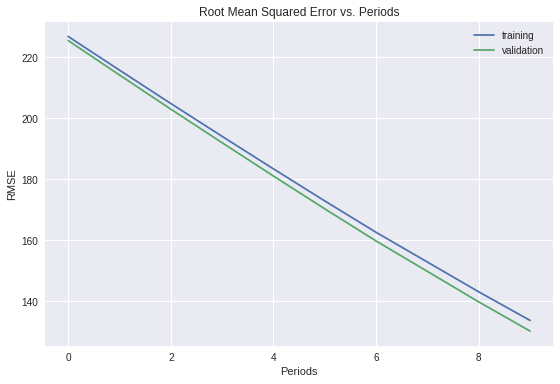

In [167]:
minimal_features = xlat

minimal_training_examples = training_examples_df[minimal_features]
minimal_validation_examples = validation_examples_df[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

Training model...
RMSE (on training data):
  period 00 : 165.97
  period 01 : 125.19
  period 02 : 122.44
  period 03 : 118.66
  period 04 : 116.30
  period 05 : 116.31
  period 06 : 116.63
  period 07 : 115.68
  period 08 : 114.49
  period 09 : 113.98
Model training finished.


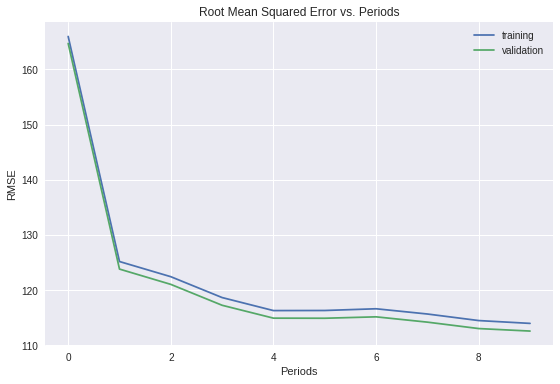

In [163]:
minimal_features = [
  "median_income",
  "latitude"
]

minimal_training_examples = training_examples[minimal_features]
minimal_validation_examples = validation_examples[minimal_features]

_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=minimal_training_examples,
    training_targets=training_targets,
    validation_examples=minimal_validation_examples,
    validation_targets=validation_targets)

In [168]:
california_housing_dataframe.latitude_bucket_II.astype('category')

2036     latitude_33_to_34
10256    latitude_38_to_39
2190     latitude_34_to_35
8014     latitude_34_to_35
7813     latitude_34_to_35
               ...        
372      latitude_32_to_33
8182     latitude_34_to_35
8081     latitude_33_to_34
8906     latitude_34_to_35
1232     latitude_33_to_34
Name: latitude_bucket_II, Length: 17000, dtype: category
Categories (11, object): [latitude_30_to_31 < latitude_31_to_32 < latitude_32_to_33 < latitude_33_to_34 <
                          ... < latitude_37_to_38 < latitude_38_to_39 < latitude_39_to_40 <
                          latitude_40_to_41]

### Solution

Click below for a solution.

Aside from `latitude`, we'll also keep `median_income`, to compare with the previous results.

We decided to bucketize the latitude. This is fairly straightforward in Pandas using `Series.apply`.

In [0]:
def select_and_transform_features(source_df):
  LATITUDE_RANGES = zip(range(32, 44), range(33, 45))
  selected_examples = pd.DataFrame()
  selected_examples["median_income"] = source_df["median_income"]
  for r in LATITUDE_RANGES:
    selected_examples["latitude_%d_to_%d" % r] = source_df["latitude"].apply(
      lambda l: 1.0 if l >= r[0] and l < r[1] else 0.0)
  return selected_examples

selected_training_examples = select_and_transform_features(training_examples)
selected_validation_examples = select_and_transform_features(validation_examples)

In [177]:
selected_training_examples.tail()

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
9659,1.9,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4307,4.6,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6488,1.5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1539,3.4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4479,2.7,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [178]:
selected_validation_examples.tail()

,median_income,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42,latitude_42_to_43,latitude_43_to_44
5787,2.2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12819,5.5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
15092,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3416,5.6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15367,0.7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [172]:
zip(range(32,44), range(33,45))

[(32, 33),
 (33, 34),
 (34, 35),
 (35, 36),
 (36, 37),
 (37, 38),
 (38, 39),
 (39, 40),
 (40, 41),
 (41, 42),
 (42, 43),
 (43, 44)]

In [180]:
for r in zip(range(32,44), range(33,45)):
  print("latitude_%d_to_%d" % r)

latitude_32_to_33
latitude_33_to_34
latitude_34_to_35
latitude_35_to_36
latitude_36_to_37
latitude_37_to_38
latitude_38_to_39
latitude_39_to_40
latitude_40_to_41
latitude_41_to_42
latitude_42_to_43
latitude_43_to_44


In [182]:
for r in zip(range(32,44), range(33,45)):
  print("latitude_{}_to_{}".format(r[0], r[1]))

latitude_32_to_33
latitude_33_to_34
latitude_34_to_35
latitude_35_to_36
latitude_36_to_37
latitude_37_to_38
latitude_38_to_39
latitude_39_to_40
latitude_40_to_41
latitude_41_to_42
latitude_42_to_43
latitude_43_to_44


Training model...
RMSE (on training data):
  period 00 : 227.67
  period 01 : 217.56
  period 02 : 207.55
  period 03 : 197.63
  period 04 : 187.80
  period 05 : 178.12
  period 06 : 168.61
  period 07 : 159.29
  period 08 : 150.17
  period 09 : 141.32
Model training finished.


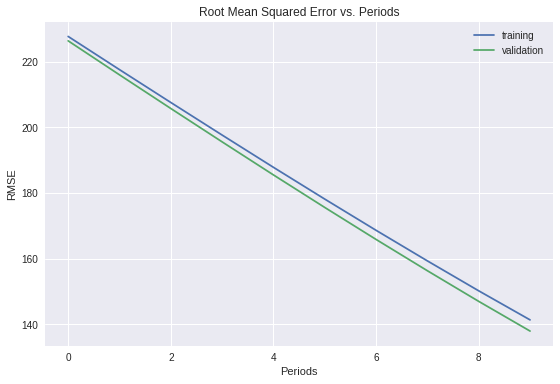

In [171]:
_ = train_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=selected_training_examples,
    training_targets=training_targets,
    validation_examples=selected_validation_examples,
    validation_targets=validation_targets)

In [183]:
california_housing_dataframe_df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_bucket,latitude_bucket_II
372,-116.9,32.8,16.0,2784.0,468.0,1458.0,465.0,4.0,184600.0,32 - 33,latitude_32_to_33
8182,-118.4,34.3,14.0,6235.0,1286.0,3568.0,1190.0,4.2,211600.0,34 - 35,latitude_34_to_35
8081,-118.4,33.9,39.0,2988.0,605.0,1466.0,610.0,4.9,341400.0,33 - 34,latitude_33_to_34
8906,-118.8,34.2,16.0,4975.0,949.0,2537.0,971.0,5.2,224700.0,34 - 35,latitude_34_to_35
1232,-117.1,33.4,17.0,2889.0,587.0,1931.0,510.0,3.9,208300.0,33 - 34,latitude_33_to_34


In [0]:
ca_housing_df = california_housing_dataframe_df.loc[:, 'longitude':'median_house_value']

In [191]:
ca_housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0


In [194]:
ca_housing_df.longitude.describe()

count   17000.0
mean     -119.6
std         2.0
min      -124.3
25%      -121.8
50%      -118.5
75%      -118.0
max      -114.3
Name: longitude, dtype: float64

In [0]:
for z in zip(range(32,42), range(33,43)):
  ca_housing_df["latitude_{}_to_{}".format(z[0], z[1])] = ca_housing_df['latitude'].apply(lambda lat: 1 if lat>z[0] and lat<z[1] else 0)

In [201]:
ca_housing_df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42
count,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0,17000.0
mean,-119.6,35.6,28.6,2643.7,539.4,1429.6,501.2,3.9,207300.9,0.1,0.2,0.2,0.0,0.1,0.2,0.1,0.0,0.0,0.0
std,2.0,2.1,12.6,2179.9,421.5,1147.9,384.5,1.9,115983.8,0.2,0.4,0.4,0.2,0.2,0.4,0.3,0.2,0.1,0.1
min,-124.3,32.5,1.0,2.0,1.0,3.0,1.0,0.5,14999.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-121.8,33.9,18.0,1462.0,297.0,790.0,282.0,2.6,119400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-118.5,34.2,29.0,2127.0,434.0,1167.0,409.0,3.5,180400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,-118.0,37.7,37.0,3151.2,648.2,1721.0,605.2,4.8,265000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,-114.3,42.0,52.0,37937.0,6445.0,35682.0,6082.0,15.0,500001.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [0]:
for z in zip(range(32,42), range(33,43)):
  ca_housing_df["lati_%d_to_%d" % z] = ca_housing_df['latitude'].apply(lambda lat: 1 if lat>z[0] and lat<z[1] else 0)

In [204]:
ca_housing_df.tail()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_32_to_33,...,lati_32_to_33,lati_33_to_34,lati_34_to_35,lati_35_to_36,lati_36_to_37,lati_37_to_38,lati_38_to_39,lati_39_to_40,lati_40_to_41,lati_41_to_42
372,-116.9,32.8,16.0,2784.0,468.0,1458.0,465.0,4.0,184600.0,1,...,1,0,0,0,0,0,0,0,0,0
8182,-118.4,34.3,14.0,6235.0,1286.0,3568.0,1190.0,4.2,211600.0,0,...,0,0,1,0,0,0,0,0,0,0
8081,-118.4,33.9,39.0,2988.0,605.0,1466.0,610.0,4.9,341400.0,0,...,0,1,0,0,0,0,0,0,0,0
8906,-118.8,34.2,16.0,4975.0,949.0,2537.0,971.0,5.2,224700.0,0,...,0,0,1,0,0,0,0,0,0,0
1232,-117.1,33.4,17.0,2889.0,587.0,1931.0,510.0,3.9,208300.0,0,...,0,1,0,0,0,0,0,0,0,0


In [198]:
ca_housing_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_32_to_33,latitude_33_to_34,latitude_34_to_35,latitude_35_to_36,latitude_36_to_37,latitude_37_to_38,latitude_38_to_39,latitude_39_to_40,latitude_40_to_41,latitude_41_to_42
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,0,1,0,0,0,0,0,0,0,0
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,0,0,0,0,0,0,1,0,0,0
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,0,0,1,0,0,0,0,0,0,0
8014,-118.4,34.3,35.0,822.0,200.0,1197.0,203.0,3.3,133300.0,0,0,1,0,0,0,0,0,0,0
7813,-118.4,34.0,44.0,1873.0,286.0,635.0,283.0,5.6,461300.0,0,0,1,0,0,0,0,0,0,0


In [192]:
california_housing_dataframe_df['longitude'].tail()

372    -116.9
8182   -118.4
8081   -118.4
8906   -118.8
1232   -117.1
Name: longitude, dtype: float64

In [0]:
for lgt in zip(range(-124, -114), range(-123, -113)):
  ca_housing_df["longitude_%d_to_%d" % lgt] = ca_housing_df["longitude"].apply(lambda long: 1 if long > lgt[0] and long < lgt[1] else 0)

In [237]:
ca_housing_df.head(3)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,latitude_32_to_33,...,longitude_-124_to_-123,longitude_-123_to_-122,longitude_-122_to_-121,longitude_-121_to_-120,longitude_-120_to_-119,longitude_-119_to_-118,longitude_-118_to_-117,longitude_-117_to_-116,longitude_-116_to_-115,longitude_-115_to_-114
2036,-117.3,34.0,27.0,5464.0,850.0,2400.0,836.0,4.7,133500.0,0,...,0,0,0,0,0,0,1,0,0,0
10256,-120.0,38.9,22.0,3119.0,640.0,786.0,351.0,3.1,118500.0,0,...,0,0,0,0,1,0,0,0,0,0
2190,-117.4,34.1,6.0,1156.0,191.0,910.0,234.0,4.9,122400.0,0,...,0,0,0,0,0,0,1,0,0,0


In [238]:
for lgt in zip(range(-124, -114), range(-123, -113)):
  print("%d and %d" % lgt)
  #ca_housing_df["longitude_%d_to_%d" % lgt] = ca_housing_df["longitude"].apply(lambda long: 1 if long > lgt[0] and long < lgt[1] else 0)

-124 and -123
-123 and -122
-122 and -121
-121 and -120
-120 and -119
-119 and -118
-118 and -117
-117 and -116
-116 and -115
-115 and -114


In [0]:
zipp = zip(range(-124, -114), range(-123, -113))

In [235]:
zipp[0][1]

-123

In [225]:
print("lgt")

lgt


In [210]:
ca_housing_df["longitude"].apply(lambda long: 1 if long > -114 and long < -113 else 0)

2036     0
10256    0
2190     0
8014     0
7813     0
        ..
372      0
8182     0
8081     0
8906     0
1232     0
Name: longitude, Length: 17000, dtype: int64

In [207]:
ca_housing_df['longitude'].tail()

372    -116.9
8182   -118.4
8081   -118.4
8906   -118.8
1232   -117.1
Name: longitude, dtype: float64